In [ ]:
!pip install datasets transformers

# Dataset Access Steps:

- Download CHIA dataset from https://figshare.com/articles/dataset/Chia_Annotated_Datasets/11855817

- Upload it a public git repo.
- Clone the git repo in colab
- Read it as a local zip file

## Notes:

- There are two files in data chia_with_scope.zip and chia_without_scope.zip. Out of which chia_with_scope.zip fails to load via dfki-nlp/brat citing formatting error. So I have used the other one.
- dfki-nlp/brat also fails to access the dataset via the link provided above. Workaround is to use public git repo.
- Whenever colab notebook reloads we lose access to uploaded data. So instead of uploading the zip file directly, use github to access it alternatively we can also use google drive to access the zip data file


In [ ]:
!git clone https://github.com/MayureshPG1/check1.git

Cloning into 'check1'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
from datasets import load_dataset

kwargs = {
"url": "/content/check1/chia_without_scope.zip",
}

dataset = load_dataset('dfki-nlp/brat', **kwargs)

Using custom data configuration default-2de4f13e909051e7


Generating train split: 0 examples [00:00, ? examples/s]

Dataset brat downloaded and prepared to /root/.cache/huggingface/datasets/dfki-nlp___brat/default-2de4f13e909051e7/0.0.0/95f9bada4009b8f29bd9a58fc18ebbc5e48e1397e590d2fef420c24685b10bf8. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

### **Split the data into 80/10/10 as train/test/dev**







In [ ]:
full_data = dataset['train']
raw_data = dataset['train'].train_test_split(test_size=.1)
raw_test = raw_data['test']
raw_train_dev =  raw_data['train']
raw_data1 = raw_train_dev.train_test_split(test_size=.1111)
raw_train = raw_data1['train']
raw_dev =  raw_data1['test']
print(full_data)
print(raw_test)
print(raw_train)
print(raw_dev)

Dataset({
    features: ['context', 'file_name', 'spans', 'relations', 'equivalence_relations', 'events', 'attributions', 'normalizations', 'notes'],
    num_rows: 2000
})
Dataset({
    features: ['context', 'file_name', 'spans', 'relations', 'equivalence_relations', 'events', 'attributions', 'normalizations', 'notes'],
    num_rows: 200
})
Dataset({
    features: ['context', 'file_name', 'spans', 'relations', 'equivalence_relations', 'events', 'attributions', 'normalizations', 'notes'],
    num_rows: 1600
})
Dataset({
    features: ['context', 'file_name', 'spans', 'relations', 'equivalence_relations', 'events', 'attributions', 'normalizations', 'notes'],
    num_rows: 200
})


### **Utility Functions performing data preparation for training.**

In [ ]:
# Get tokens and entities directly. We dont need to read end and start positions as tokens are directly given as text and entities as type
def get_tokens_with_entities(data):
  tokens_with_entities = []
  data_text = data['spans']['text']
  data_type = data['spans']['type']
  for index,_ in enumerate(data_text):
    tokens_with_entities.append((data_text[index],data_type[index]))

  return tokens_with_entities

#Utility class to prepare data
class NERDataMaker:
    def __init__(self, raw_data):
        self.unique_entities = []
        self.processed_texts = []

        temp_processed_texts = []
        for text in raw_data:
          tokens_with_entities = get_tokens_with_entities(text)
          for _, ent in tokens_with_entities:
              if ent not in self.unique_entities:
                  self.unique_entities.append(ent)
          temp_processed_texts.append(tokens_with_entities)

        #sort the entities as different datasets may have different ordering
        self.unique_entities.sort()
        for tokens_with_entities in temp_processed_texts:
          for t, ent in tokens_with_entities:
            self.processed_texts.append([(t, self.unique_entities.index(ent))])

    @property
    def id2label(self):
        return dict(enumerate(self.unique_entities))

    @property
    def label2id(self):
        return {v:k for k, v in self.id2label.items()}

    def __len__(self):
        return len(self.processed_texts)

    def __getitem__(self, idx):
        def _process_tokens_for_one_text(id, tokens_with_encoded_entities):
            ner_tags = []
            tokens = []
            for t, ent in tokens_with_encoded_entities:
                ner_tags.append(ent)
                tokens.append(t)

            return {
                "id": id,
                "ner_tags": ner_tags,
                "tokens": tokens
            }

        tokens_with_encoded_entities = self.processed_texts[idx]
        if isinstance(idx, int):
            return _process_tokens_for_one_text(idx, tokens_with_encoded_entities)
        else:
            return [_process_tokens_for_one_text(i+idx.start, tee) for i, tee in enumerate(tokens_with_encoded_entities)]

    def get_dataset(self, tokenizer):
        from datasets import Dataset, Features, Value, ClassLabel, Sequence
        def tokenize_and_align_labels(examples):
            tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

            labels = []
            for i, label in enumerate(examples[f"ner_tags"]):
                word_ids = tokenized_inputs.word_ids(batch_index=i)
                previous_word_idx = None
                label_ids = []
                for word_idx in word_ids:
                    if word_idx is None:
                        label_ids.append(-100)
                    elif word_idx != previous_word_idx:
                        label_ids.append(label[word_idx])
                    else:
                        label_ids.append(-100)
                    previous_word_idx = word_idx
                labels.append(label_ids)

            tokenized_inputs["labels"] = labels
            return tokenized_inputs

        ids, ner_tags, tokens = [], [], []
        for i, pt in enumerate(self.processed_texts):
            ids.append(i)
            pt_tokens,pt_tags = list(zip(*pt))
            ner_tags.append(pt_tags)
            tokens.append(pt_tokens)
        data = {
            "id": ids,
            "ner_tags": ner_tags,
            "tokens": tokens
        }
        features = Features({
            "tokens": Sequence(Value("string")),
            "ner_tags": Sequence(ClassLabel(names=self.unique_entities)),
            "id": Value("int32")
        })
        ds = Dataset.from_dict(data, features)
        tokenized_ds = ds.map(tokenize_and_align_labels, batched=True)
        return tokenized_ds

### **Displaying status of prepared data**

In [ ]:
full_dm = NERDataMaker(full_data)
print(f"total full examples = {len(full_dm)}")
print(f"total unique ent = {len(full_dm.unique_entities)}")
print(f"unique ent = {full_dm.unique_entities}")

test_dm = NERDataMaker(raw_test)
print(f"total test examples = {len(test_dm)}")
print(f"total unique ent = {len(test_dm.unique_entities)}")
print(f"unique ent = {test_dm.unique_entities}")
# print(test_dm[0:3])

train_dm = NERDataMaker(raw_train)
print(f"total train examples = {len(train_dm)}")
print(f"total unique ent = {len(train_dm.unique_entities)}")
print(f"unique ent = {train_dm.unique_entities}")

dev_dm = NERDataMaker(raw_dev)
print(f"total train examples = {len(dev_dm)}")
print(f"total unique ent = {len(dev_dm.unique_entities)}")
print(f"unique ent = {dev_dm.unique_entities}")

total full examples = 44616
total unique ent = 30
unique ent = ['Competing_trial', 'Condition', 'Context_Error', 'Device', 'Drug', 'Grammar_Error', 'Informed_consent', 'Intoxication_considerations', 'Line', 'Measurement', 'Mood', 'Multiplier', 'Negation', 'Non-query-able', 'Non-representable', 'Not_a_criteria', 'Observation', 'Parsing_Error', 'Person', 'Post-eligibility', 'Pregnancy_considerations', 'Procedure', 'Qualifier', 'Reference_point', 'Subjective_judgement', 'Temporal', 'Undefined_semantics', 'Value', 'Visit', 'c-Requires_causality']
total test examples = 4431
total unique ent = 29
unique ent = ['Competing_trial', 'Condition', 'Context_Error', 'Device', 'Drug', 'Grammar_Error', 'Informed_consent', 'Intoxication_considerations', 'Line', 'Measurement', 'Mood', 'Multiplier', 'Negation', 'Non-query-able', 'Non-representable', 'Not_a_criteria', 'Observation', 'Parsing_Error', 'Person', 'Post-eligibility', 'Pregnancy_considerations', 'Procedure', 'Qualifier', 'Reference_point', 'Sub

### **Use Tokenizer, datacollector and model based on distilbert-base-uncased**

In [ ]:
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments, Trainer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(full_dm.unique_entities), id2label=full_dm.id2label, label2id=full_dm.label2id)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

### **Define metric data for evaluation**

In [ ]:
!pip install seqeval

In [ ]:
from datasets import load_metric
import numpy as np
metric = load_metric("seqeval")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    label_list = full_dm.unique_entities
    true_labels = [[label_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

### **Build training args, Trainer and Train**

- Evaluation details and metrices shown in the output.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,#40,
    weight_decay=0.01,
)

test_ds = test_dm.get_dataset(tokenizer=tokenizer)
train_ds = train_dm.get_dataset(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/36 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: id, tokens, ner_tags. If id, tokens, ner_tags are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 35755
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2235


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.686900,0.653394,0.827229,0.832792,0.830001,0.820582


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1500/special_toke

{'epoch': 1.0,
 'eval_accuracy': 0.8205822613405552,
 'eval_f1': 0.8300011556685543,
 'eval_loss': 0.6533944606781006,
 'eval_precision': 0.8272287491361437,
 'eval_recall': 0.8327922077922078,
 'eval_runtime': 162.4394,
 'eval_samples_per_second': 27.278,
 'eval_steps_per_second': 1.705}

### **Use pipeline to test the data output**

In [ ]:
from transformers import pipeline

pipe = pipeline("ner", model=model,tokenizer=tokenizer, aggregation_strategy="simple")
pipe(dev_dm)

# Results Summery

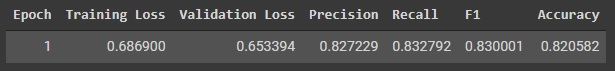

{
  'epoch': 1.0,

 'eval_accuracy': 0.8205822613405552,

 'eval_f1': 0.8300011556685543,

 'eval_loss': 0.6533944606781006,

 'eval_precision': 0.8272287491361437,

 'eval_recall': 0.8327922077922078,

 'eval_runtime': 162.4394,

 'eval_samples_per_second': 27.278,

 'eval_steps_per_second': 1.705
 }



